In [0]:
import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2/wiki_data')
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2')

In [2]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

import os
import sys
from utils import get_wikipedia_data, get_bigram_probs
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

In [0]:
def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

In [0]:
def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1-decay) * x[t]
        y[t] = z / (1 - decay**(t+1))
        last = z

    return y

In [6]:
if __name__ == '__main__':
    #load data
    # sentences are already converted to sequences of word indexes
    #we can limit the vocab size if memory constraints
    sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)
    #sentences, word2idx = get_sentences_with_word2idx()

    #vocab size
    V = len(word2idx)
    print("Vocab size:", V)

    #we wil treat start and end of the sentences as bigrams
    #first word --> START
    #last word --> END
    start_idx = word2idx['START']
    end_idx = word2idx['END']

    #a matrix where:
    #row = last word
    #col = current word
    #value at [row, col]  = p(current word | last word)
    bigram_probs = get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=0.1)

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

In [0]:
#train a shallow neural network
D = 100
W1 = np.random.randn(V, D) / np.sqrt(V)
W2 = np.random.randn(D, V) / np.sqrt(D)

losses = []
epochs = 1
lr = 1e-2

In [0]:
#bigram weight
W_bigram = np.log(bigram_probs)
bigram_losses = []

In [11]:
  t0 = datetime.now()
  for epoch in range(epochs):
    # shuffle sentences at each epoch
    random.shuffle(sentences)

    j = 0 # keep track of iterations
    for sentence in sentences:
      # do not one-hot encoded inputs and targets
      sentence = [start_idx] + sentence + [end_idx]
      n = len(sentence)
      inputs = sentence[:n-1]
      targets = sentence[1:]

      # get output predictions
      hidden = np.tanh(W1[inputs])
      predictions = softmax(hidden.dot(W2))

      # keep track of the loss
      loss = -np.sum(np.log(predictions[np.arange(n - 1), targets])) / (n - 1)
      losses.append(loss)

      # do a gradient descent step
      # do it after loss since the calculation of doutput will overwrite predictions
      # we don't want to make a copy because it would be slow
      doutput = predictions # N x V
      doutput[np.arange(n - 1), targets] -= 1
      W2 = W2 - lr * hidden.T.dot(doutput) # (D x N) (N x V)
      dhidden = doutput.dot(W2.T) * (1 - hidden * hidden) # (N x V) (V x D) * (N x D)
      # # for reference:
      # # original: W1 = W1 - lr * inputs.T.dot(dhidden) # VxN NxD --> VxD

      # fastest way
      np.subtract.at(W1, inputs, lr * dhidden)

      # test this
      # i = 0
      # for w in inputs: # don't include end token
      #   W1[w] = W1[w] - lr * dhidden[i]
      #   i += 1

      # vs this
      # oh_inputs = np.zeros((n - 1, V))
      # oh_inputs[np.arange(n - 1), sentence[:n-1]] = 1
      # W1 = W1 - lr * oh_inputs.T.dot(dhidden)

      # keep track of the bigram loss
      # only do it for the first epoch to avoid redundancy
      if epoch == 0:
        bigram_predictions = softmax(W_bigram[inputs])
        bigram_loss = -np.sum(np.log(bigram_predictions[np.arange(n - 1), targets])) / (n - 1)
        bigram_losses.append(bigram_loss)


      if j % 100 == 0:
        print("epoch:", epoch, "sentence: %s/%s" % (j, len(sentences)), "loss:", loss)
      j += 1


epoch: 0 sentence: 0/57013 loss: 7.603128476308808
epoch: 0 sentence: 100/57013 loss: 7.419227376500333
epoch: 0 sentence: 200/57013 loss: 6.86234733993339
epoch: 0 sentence: 300/57013 loss: 6.253656290223138
epoch: 0 sentence: 400/57013 loss: 4.57825639440015
epoch: 0 sentence: 500/57013 loss: 4.464195417081601
epoch: 0 sentence: 600/57013 loss: 5.111927360225187
epoch: 0 sentence: 700/57013 loss: 4.778716954628163
epoch: 0 sentence: 800/57013 loss: 6.751857386414456
epoch: 0 sentence: 900/57013 loss: 5.489037011412009
epoch: 0 sentence: 1000/57013 loss: 4.950524905979014
epoch: 0 sentence: 1100/57013 loss: 5.600386748072498
epoch: 0 sentence: 1200/57013 loss: 6.226395707986952
epoch: 0 sentence: 1300/57013 loss: 6.202577657008044
epoch: 0 sentence: 1400/57013 loss: 6.971553772265725
epoch: 0 sentence: 1500/57013 loss: 5.660391085205653
epoch: 0 sentence: 1600/57013 loss: 7.115137923411287
epoch: 0 sentence: 1700/57013 loss: 5.011939633062395
epoch: 0 sentence: 1800/57013 loss: 3.9603

Elapsed time training: 0:06:19.278910


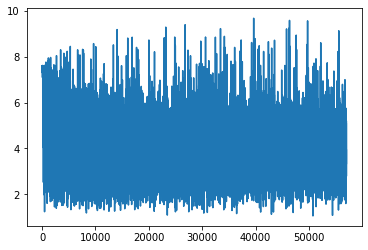

In [12]:
print("Elapsed time training:", datetime.now() - t0)
plt.plot(losses)


avg_bigram_loss: 3.7779453269292613


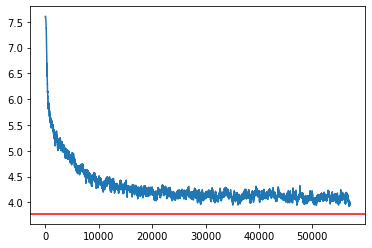

In [16]:
# plot a horizontal line for the bigram loss
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')
plt.plot(smoothed_loss(losses))
plt.show()

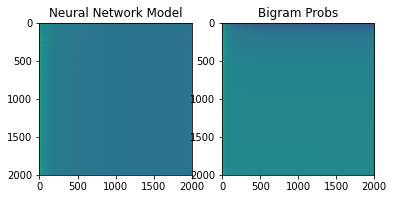

In [14]:
# plot W and bigram probs side-by-side
# for the most common 200 words
plt.subplot(1,2,1)
plt.title("Neural Network Model")
plt.imshow(np.tanh(W1).dot(W2))
plt.subplot(1,2,2)
plt.title("Bigram Probs")
plt.imshow(W_bigram)
plt.show()
